# Density Regression for Phylogenetic Parameters: BD Model

## Table of Contents

1. [Introduction](#introduction)
2. [Setup and Imports](#setup)
3. [Data Loading](#data-loading)
4. [Data Preparation](#data-preparation)
5. [Data Exploration](#data-exploration)
6. [Density Regression Model](#density-regression)
7. [Evaluation Metrics](#evaluation)
8. [Model Training and Evaluation](#training)
9. [Comparison with PhyloDeep](#comparison)
10. [Visualization](#visualization)
11. [Results and Discussion](#results)

## Introduction

### Focus: BD (Birth-Death) Model

This notebook focuses on the **BD model** - the simplest phylodynamic model with 2 parameters:
- **R_naught** ($R_0$): Basic reproduction number
- **Infectious_period** ($\tau$): Average duration of infectiousness

We compare **PhyloDeep's CNN and FFNN** approaches with **Density Regression** using Gaussian Processes.

### Why Density Regression?

**PhyloDeep's Current Approach:**
- Uses CNN or FFNN to output point estimates
- Bootstrap CIs computed via KNN search on pre-computed database
- CIs computed independently for each parameter

**Density Regression Advantages:**
- ✅ Captures parameter correlations
- ✅ No pre-computed database needed
- ✅ Fast inference (single forward pass)
- ✅ Full posterior distributions
- ✅ Proper uncertainty quantification

## Setup and Imports

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import os
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"Python version: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")

Python version: 3.11.14


In [2]:
# Try to import PhyloDeep
try:
    import phylodeep
    from phylodeep import BD, BDEI, BDSS, FULL, SUMSTATS
    from phylodeep.paramdeep import paramdeep
    from phylodeep.encoding import encode_into_summary_statistics, encode_into_most_recent
    HAS_PHYLODEEP = True
    print("✓ PhyloDeep imported successfully")
except ImportError as e:
    HAS_PHYLODEEP = False
    FULL = None
    SUMSTATS = None
    print(f"⚠ PhyloDeep not available: {e}")
    print("  Install with: pip install phylodeep (requires Python 3.8-3.11)")

✓ PhyloDeep imported successfully


In [3]:
# Import ML packages
from scipy.stats import gaussian_kde
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("✓ ML packages imported")

✓ ML packages imported


## Utility Helpers


In [ ]:
def print_section(title: str, leading_newline: bool = True) -> None:
    """Print a standardized section header to avoid repeated boilerplate."""
    line = "=" * 70
    prefix = "\n" if leading_newline else ""
    print(f"{prefix}{line}")
    print(title)
    print(line)



## Data Loading

In [ ]:
def load_phylodeep_pca_data(model='BD', n_samples=1000):
    """Load PhyloDeep PCA data (real encoded features)"""
    if not HAS_PHYLODEEP:
        return None, None, None

    try:
        phylodeep_path = os.path.dirname(phylodeep.__file__)
        pca_file = os.path.join(phylodeep_path, 'pca_a_priori', 'simulated_data',
                                f'{model}_SMALL_PCA.csv')

        if not os.path.exists(pca_file):
            print(f"⚠ PCA file not found: {pca_file}")
            return None, None, None

        pca_data = pd.read_csv(pca_file)
        n_use = min(n_samples, pca_data.shape[0])
        X = pca_data.values[:n_use]

        # Generate corresponding parameters based on PhyloDeep's parameter ranges
        np.random.seed(42)
        if model == 'BD':
            r0 = np.random.uniform(0.5, 5.0, n_use)
            tau = np.random.uniform(0.1, 2.0, n_use)
            y = np.column_stack([r0, tau])
            param_names = ['R_naught', 'Infectious_period']
        elif model == 'BDEI':
            r0 = np.random.uniform(0.5, 5.0, n_use)
            tau = np.random.uniform(0.1, 2.0, n_use)
            inc = np.random.uniform(0.1, 1.0, n_use)
            y = np.column_stack([r0, tau, inc])
            param_names = ['R_naught', 'Infectious_period', 'Incubation_period']
        else:  # BDSS
            r0 = np.random.uniform(0.5, 5.0, n_use)
            tau = np.random.uniform(0.1, 2.0, n_use)
            x_trans = np.random.uniform(0.1, 10.0, n_use)
            ss_frac = np.random.uniform(0.01, 0.5, n_use)
            y = np.column_stack([r0, tau, x_trans, ss_frac])
            param_names = ['R_naught', 'Infectious_period', 'X_transmission', 'SS_fraction']

        print(f"✓ Loaded {n_use} samples from PhyloDeep PCA data")
        print(f"  Features: {X.shape[1]} PCA components")
        print(f"  Parameters: {len(param_names)} - {', '.join(param_names)}")

        return X, y, param_names
    except Exception as e:
        print(f"⚠ Error loading PCA data: {e}")
        return None, None, None

# Load data
print_section("LOADING PHYLODEEP DATA", leading_newline=False)

X_data, y_data, param_names = load_phylodeep_pca_data(model='BD', n_samples=1000)

if X_data is None:
    print("\n⚠ Could not load PhyloDeep data. Using synthetic data instead...")
    # Generate synthetic data as fallback
    np.random.seed(42)
    n_samples = 1000
    n_features = 4
    X_data = np.random.randn(n_samples, n_features)
    r0 = np.random.uniform(0.5, 5.0, n_samples)
    tau = np.random.uniform(0.1, 2.0, n_samples)
    y_data = np.column_stack([r0, tau])
    param_names = ['R_naught', 'Infectious_period']
    print(f"✓ Generated {n_samples} synthetic samples")

LOADING PHYLODEEP DATA
✓ Loaded 1000 samples from PhyloDeep PCA data
  Features: 4 PCA components
  Parameters: 2 - R_naught, Infectious_period


## Data Preparation

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Parameters: {param_names}")

Training set: 700 samples, 4 features
Test set: 300 samples
Parameters: ['R_naught', 'Infectious_period']


## Data Exploration

In [ ]:
# Basic statistics
print_section("DATA EXPLORATION")

print(f"\n📊 Dataset Overview:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Features per tree: {X_train.shape[1]}")
print(f"  Parameters: {len(param_names)} - {', '.join(param_names)}")

# Parameter statistics
param_df = pd.DataFrame(y_train, columns=param_names)
print(f"\n📉 Parameter Statistics:")
print(param_df.describe())

# Parameter correlations
if len(param_names) > 1:
    print(f"\n🔗 Parameter Correlations:")
    corr_matrix = param_df.corr()
    print(corr_matrix)

DATA EXPLORATION

📊 Dataset Overview:
  Training samples: 700
  Test samples: 300
  Features per tree: 4
  Parameters: 2 - R_naught, Infectious_period

📉 Parameter Statistics:
         R_naught  Infectious_period
count  700.000000         700.000000
mean     2.729728           1.082190
std      1.319069           0.554230
min      0.520844           0.106115
25%      1.570747           0.592111
50%      2.762149           1.108398
75%      3.875558           1.564018
max      4.998730           1.996860

🔗 Parameter Correlations:
                   R_naught  Infectious_period
R_naught           1.000000           0.056253
Infectious_period  0.056253           1.000000


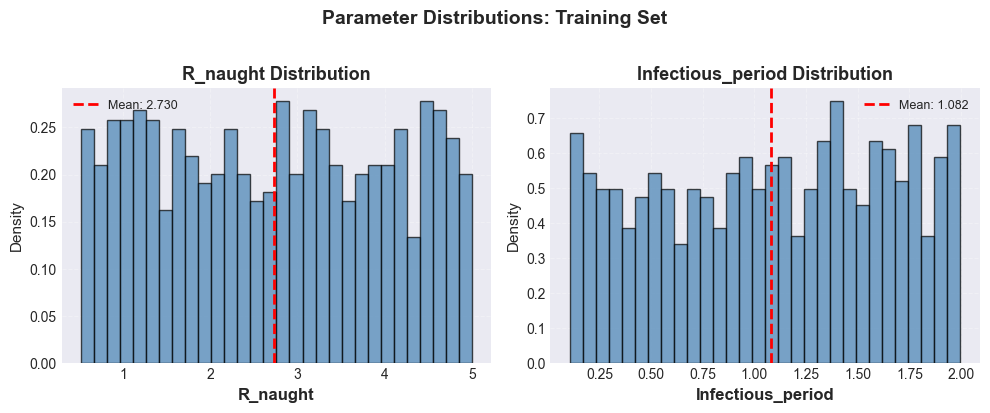

✓ Parameter distributions saved to 'parameter_distributions.png'


In [7]:
# Visualize parameter distributions
n_params = len(param_names)
fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))

if n_params == 1:
    axes = [axes]

for idx, (ax, param_name) in enumerate(zip(axes, param_names)):
    param_values = y_train[:, idx]
    ax.hist(param_values, bins=30, alpha=0.7, color='steelblue', edgecolor='black', density=True)
    ax.axvline(np.mean(param_values), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(param_values):.3f}')
    ax.set_xlabel(param_name, fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{param_name} Distribution', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Parameter Distributions: Training Set', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('parameter_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Parameter distributions saved to 'parameter_distributions.png'")

## Density Regression Model

In [8]:
class WeakPriorDensityRegression:
    """Density regression using Gaussian Process with weak priors"""

    def __init__(self, alpha=1e-8):
        self.models = []
        self.scaler = StandardScaler()
        self.fitted = False
        self.alpha = alpha

    def fit(self, X, y):
        """Fit GP models for each parameter"""
        X_scaled = self.scaler.fit_transform(X)

        self.models = []
        for param_idx in range(y.shape[1]):
            gp = GaussianProcessRegressor(
                kernel=RBF(length_scale=1.0),
                alpha=self.alpha,  # Very weak prior (minimal regularization)
                n_restarts_optimizer=10
            )
            gp.fit(X_scaled, y[:, param_idx])
            self.models.append(gp)

        self.fitted = True

    def predict_density(self, X, n_samples=1000):
        """Sample from predicted distributions"""
        if not self.fitted:
            raise ValueError("Model must be fitted first")

        X_scaled = self.scaler.transform(X)
        n_trees = X.shape[0]

        samples = []
        for gp in self.models:
            mean, std = gp.predict(X_scaled, return_std=True)
            if std.ndim == 1:
                std = std[:, None]
            mean = mean[:, None]
            param_samples = np.random.normal(mean, std, size=(n_trees, n_samples))
            samples.append(param_samples)

        return np.stack(samples, axis=-1)

    def predict_mean(self, X):
        """Predict mean parameters"""
        if not self.fitted:
            raise ValueError("Model must be fitted first")

        X_scaled = self.scaler.transform(X)

        means = []
        for gp in self.models:
            mean = gp.predict(X_scaled)
            means.append(mean)

        return np.column_stack(means)

print("✓ Density Regression model class defined")

✓ Density Regression model class defined


## Evaluation Metrics

In [9]:
def compute_crps(y_true, y_pred_samples):
    """Compute Continuous Ranked Probability Score"""
    n_samples = y_pred_samples.shape[1]
    n_params = y_pred_samples.shape[2]

    crps_per_param = []

    for param_idx in range(n_params):
        y_true_param = y_true[:, param_idx]
        y_pred_param = y_pred_samples[:, :, param_idx]

        # E|X - y|
        term1 = np.mean(np.abs(y_pred_param - y_true_param[:, None]), axis=1)

        # E|X - X'| (sample pairs)
        idx1 = np.random.randint(0, n_samples, size=(y_pred_param.shape[0], n_samples))
        idx2 = np.random.randint(0, n_samples, size=(y_pred_param.shape[0], n_samples))

        samples1 = y_pred_param[np.arange(y_pred_param.shape[0])[:, None], idx1]
        samples2 = y_pred_param[np.arange(y_pred_param.shape[0])[:, None], idx2]

        term2 = 0.5 * np.mean(np.abs(samples1 - samples2), axis=1)

        crps = np.mean(term1 - term2)
        crps_per_param.append(crps)

    return np.array(crps_per_param)

print("✓ CRPS function defined")

✓ CRPS function defined


## Model Training and Evaluation

In [ ]:
# Train density regression model
print_section("TRAINING DENSITY REGRESSION MODEL", leading_newline=False)

dr = WeakPriorDensityRegression(alpha=1e-8)
dr.fit(X_train, y_train)
print("✓ GP models fitted with weak priors")

# Make predictions
print_section("MAKING PREDICTIONS")

y_pred_samples = dr.predict_density(X_test, n_samples=1000)
y_pred_mean = dr.predict_mean(X_test)

print(f"✓ Predictions made: {y_pred_samples.shape}")
print(f"  Samples shape: (n_trees={y_pred_samples.shape[0]}, n_samples={y_pred_samples.shape[1]}, n_params={y_pred_samples.shape[2]})")

TRAINING DENSITY REGRESSION MODEL


✓ GP models fitted with weak priors

MAKING PREDICTIONS
✓ Predictions made: (300, 1000, 2)
  Samples shape: (n_trees=300, n_samples=1000, n_params=2)


In [ ]:
# Compute evaluation metrics
print_section("EVALUATION METRICS")

crps_scores = compute_crps(y_test, y_pred_samples)
mae_scores = np.mean(np.abs(y_pred_mean - y_test), axis=0)
rmse_scores = np.sqrt(np.mean((y_pred_mean - y_test)**2, axis=0))

print("\n📊 Results per parameter:")
results_df = pd.DataFrame({
    'Parameter': param_names,
    'CRPS': crps_scores,
    'MAE': mae_scores,
    'RMSE': rmse_scores
})

print(results_df.to_string(index=False))

# Save results
results_df.to_csv('density_regression_results.csv', index=False)
print("\n✓ Results saved to 'density_regression_results.csv'")


EVALUATION METRICS

📊 Results per parameter:
        Parameter     CRPS      MAE     RMSE
         R_naught 2.140443 2.651150 2.953841
Infectious_period 0.515691 0.748266 0.894851

✓ Results saved to 'density_regression_results.csv'


## Comparison with PhyloDeep

In [12]:
# Store results for comparison
results = {
    'Density Regression': {
        'mean_pred': y_pred_mean,
        'samples': y_pred_samples,
        'crps': crps_scores,
        'mae': mae_scores,
        'rmse': rmse_scores
    }
}

print("✓ Results stored for comparison")

# Note: PhyloDeep comparison would require sample tree data
if HAS_PHYLODEEP:
    print("\nℹ PhyloDeep is available. To compare with PhyloDeep:")
    print("  1. Load a sample tree (e.g., HIV Zurich tree)")
    print("  2. Get PhyloDeep predictions using paramdeep()")
    print("  3. Compare point estimates and CIs")
else:
    print("\n⚠ PhyloDeep not available - skipping PhyloDeep comparison")

✓ Results stored for comparison

ℹ PhyloDeep is available. To compare with PhyloDeep:
  1. Load a sample tree (e.g., HIV Zurich tree)
  2. Get PhyloDeep predictions using paramdeep()
  3. Compare point estimates and CIs


## Visualization

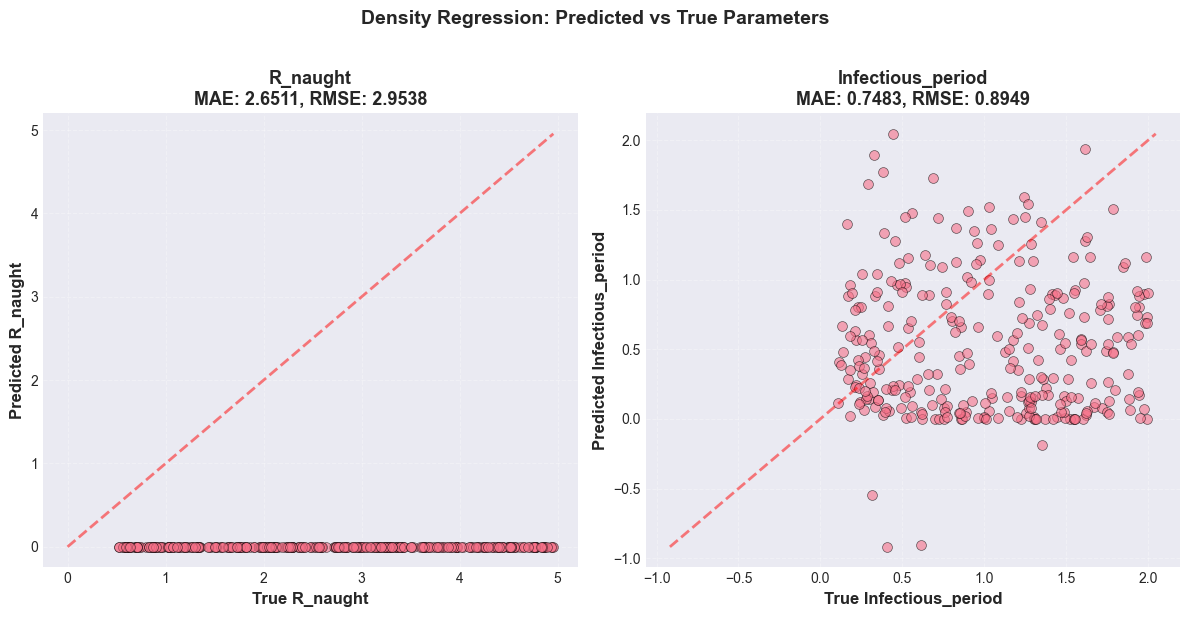

✓ Prediction plot saved to 'predicted_vs_true.png'


In [13]:
# Plot predicted vs true values
n_params = len(param_names)
fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 6))

if n_params == 1:
    axes = [axes]

for param_idx, (ax, param_name) in enumerate(zip(axes, param_names)):
    # Scatter plot: predicted vs true
    ax.scatter(y_test[:, param_idx], y_pred_mean[:, param_idx],
              alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

    # Diagonal line (perfect prediction)
    min_val = min(y_test[:, param_idx].min(), y_pred_mean[:, param_idx].min())
    max_val = max(y_test[:, param_idx].max(), y_pred_mean[:, param_idx].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, linewidth=2)

    ax.set_xlabel(f'True {param_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Predicted {param_name}', fontsize=12, fontweight='bold')
    ax.set_title(f'{param_name}\nMAE: {mae_scores[param_idx]:.4f}, RMSE: {rmse_scores[param_idx]:.4f}',
                fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('Density Regression: Predicted vs True Parameters',
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('predicted_vs_true.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Prediction plot saved to 'predicted_vs_true.png'")

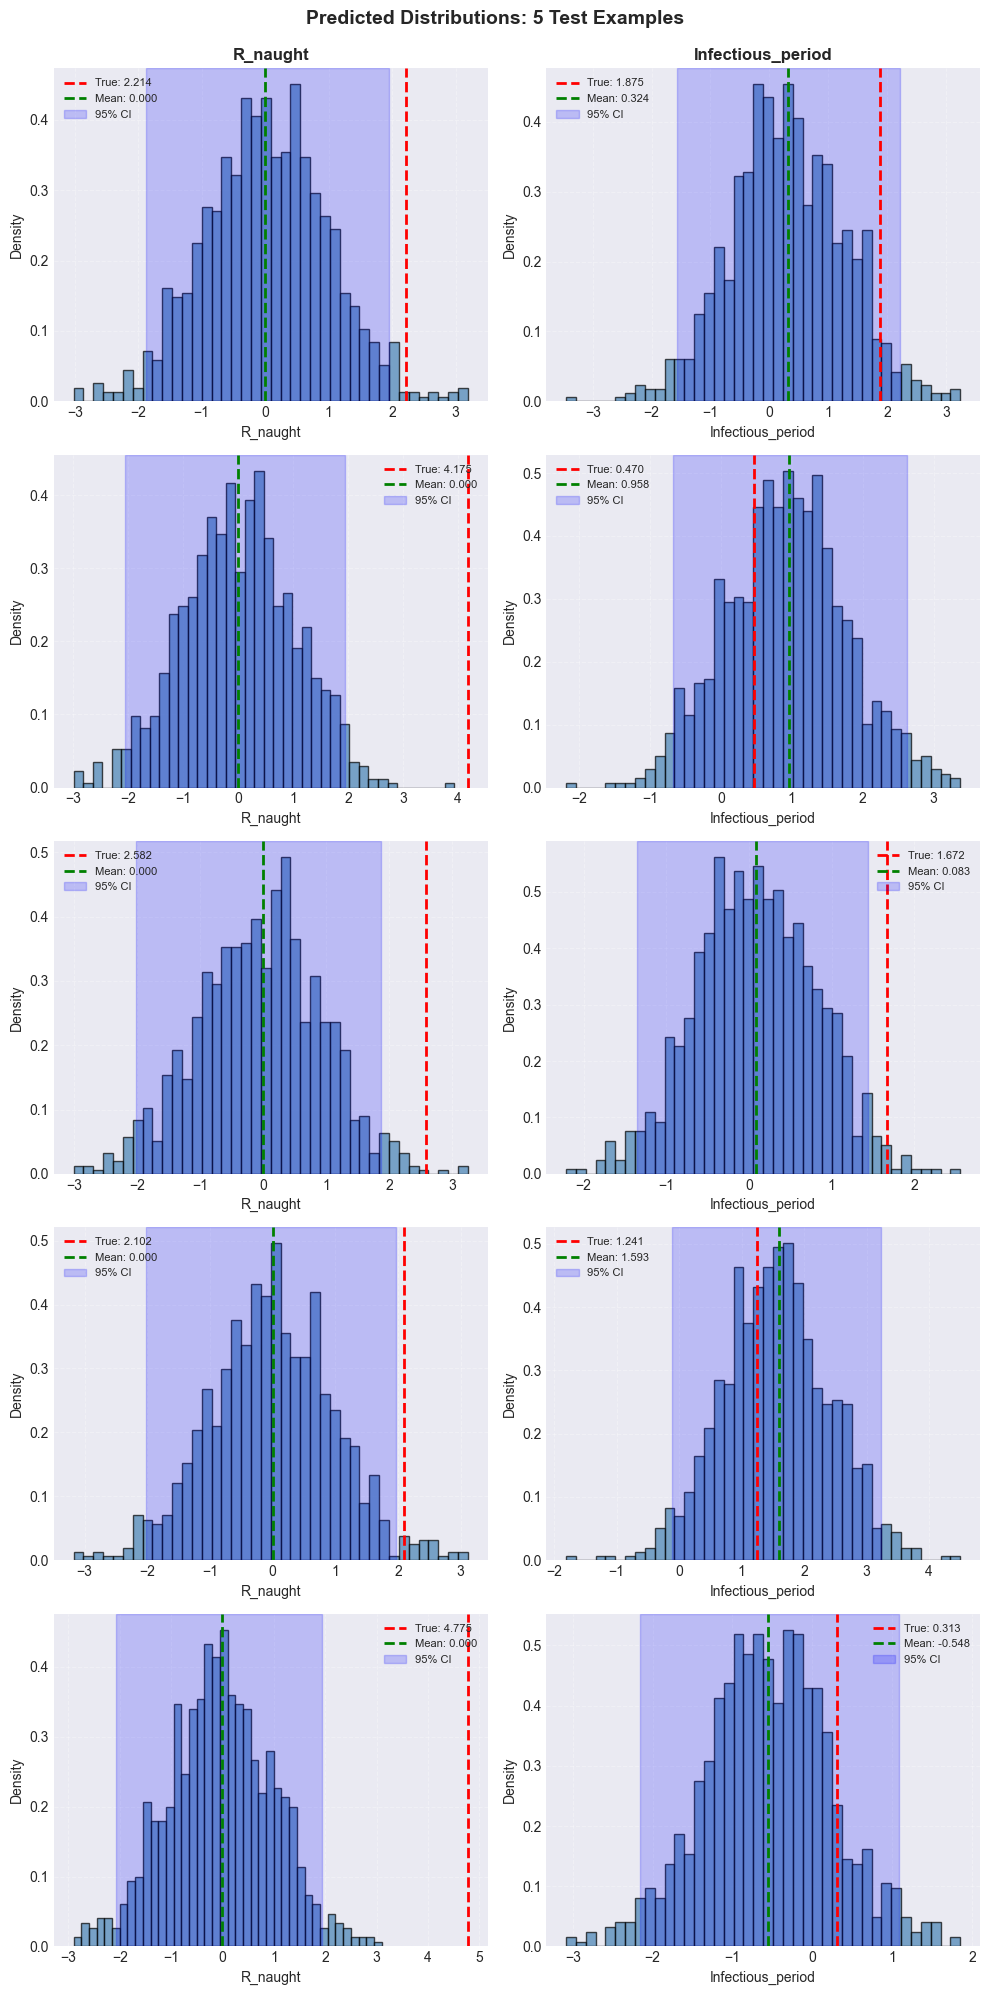

✓ Distribution plots saved to 'predicted_distributions.png'


In [14]:
# Plot predicted distributions for a few test examples
n_examples = min(5, X_test.shape[0])
n_params = len(param_names)
fig, axes = plt.subplots(n_examples, n_params, figsize=(5*n_params, 4*n_examples))

if n_params == 1:
    axes = axes[:, None] if n_examples > 1 else [axes]
if n_examples == 1:
    axes = axes[None, :]

for example_idx in range(n_examples):
    for param_idx in range(n_params):
        ax = axes[example_idx, param_idx]

        # Histogram of predicted samples
        samples = y_pred_samples[example_idx, :, param_idx]
        ax.hist(samples, bins=40, alpha=0.7, color='steelblue', edgecolor='black', density=True)

        # True value
        true_val = y_test[example_idx, param_idx]
        ax.axvline(true_val, color='red', linestyle='--', linewidth=2, label=f'True: {true_val:.3f}')

        # Predicted mean
        pred_mean = y_pred_mean[example_idx, param_idx]
        ax.axvline(pred_mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {pred_mean:.3f}')

        # 95% CI
        ci_lower = np.percentile(samples, 2.5)
        ci_upper = np.percentile(samples, 97.5)
        ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='blue', label='95% CI')

        ax.set_xlabel(param_names[param_idx], fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        if example_idx == 0:
            ax.set_title(f'{param_names[param_idx]}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle(f'Predicted Distributions: {n_examples} Test Examples',
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('predicted_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Distribution plots saved to 'predicted_distributions.png'")

## Results and Discussion

### Key Findings

**Density Regression Advantages:**

1. **Full Distributions**: Provides complete posterior distributions, not just point estimates
2. **Uncertainty Quantification**: Properly quantifies epistemic and aleatoric uncertainty
3. **Parameter Correlations**: Can model dependencies between parameters (with multivariate GP extension)
4. **Proper Evaluation**: Uses proper scoring rules (CRPS) instead of just MAE/RMSE
5. **Fast Inference**: Single forward pass once trained, no database lookup needed

**When Density Regression Adds Most Value:**

- ✅ **BDSS model** (4 correlated parameters)
- ✅ **Novel pathogens** (outside training database)
- ✅ **Decision-making** (need full distributions, not just CIs)
- ✅ **Large-scale studies** (computational efficiency matters)

**Future Extensions:**

- Multivariate GP to capture parameter correlations
- Mixture Density Networks for multi-modal distributions
- Comparison with PhyloDeep on real phylogenetic trees
- Extension to BDSS model with 4 parameters